In [2]:
#https://github.com/jswhit/pyspharm/blob/master/examples/galewskyetal_testcase.py

# non-linear barotropically unstable shallow water test case
# of Galewsky et al (2004, Tellus, 56A, 429-440).
# "An initial-value problem for testing numerical models of the global
# shallow-water equations"
# http://www-vortex.mcs.st-and.ac.uk/~rks/reprints/galewsky_etal_tellus_2004.pdf


from __future__ import print_function
import numpy as np
from spharm import Spharmt, getspecindx
import matplotlib.pyplot as plt

#from mpl_toolkits.basemap import Basemap, addcyclic
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import time

In [3]:
# grid, time step info
nlons = 256  # number of longitudes
ntrunc = 84 # spectral truncation (for alias-free computations)

nlats = int((nlons/2))+1 # for regular grid.
gridtype = 'regular'

#nlats = int(nlons/2) # for gaussian grid.
#gridtype = 'gaussian'

dt = 150 # time step in seconds
itmax = int(6*(86400/dt)) # integration length in days

In [4]:
# parameters for test
rsphere = 6.37122e6 # earth radius
omega = 7.292e-5 # rotation rate
grav = 9.80616 # gravity
hbar = 10.e3 # resting depth
umax = 80. # jet speed
phi0 = np.pi/7.; phi1 = 0.5*np.pi - phi0; phi2 = 0.25*np.pi
en = np.exp(-4.0/(phi1-phi0)**2)
alpha = 1./3.; beta = 1./15.
hamp = 120. # amplitude of height perturbation to zonal jet
efold = 3.*3600. # efolding timescale at ntrunc for hyperdiffusion
ndiss = 8 # order for hyperdiffusion

In [5]:
# setup up spherical harmonic instance, set lats/lons of grid

x = Spharmt(nlons,nlats,rsphere=rsphere,gridtype=gridtype)
delta = 2.*np.pi/nlons
lats1d = 0.5*np.pi-delta*np.arange(nlats)
lons1d = np.arange(-np.pi,np.pi,delta)
lons,lats = np.meshgrid(lons1d,lats1d)
f = 2.*omega*np.sin(lats) # coriolis

In [6]:
# zonal jet.
vg = np.zeros((nlats,nlons),np.float32)
u1 = (umax/en)*np.exp(1./((lats1d-phi0)*(lats1d-phi1)))
ug = np.zeros((nlats),np.float32)
ug = np.where(np.logical_and(lats1d < phi1, lats1d > phi0), u1, ug)
ug.shape = (nlats,1)
ug = ug*np.ones((nlats,nlons),dtype=np.float32) # broadcast to shape (nlats,nlonss)
# height perturbation.
hbump = hamp*np.cos(lats)*np.exp(-(lons/alpha)**2)*np.exp(-(phi2-lats)**2/beta)

(129, 256)


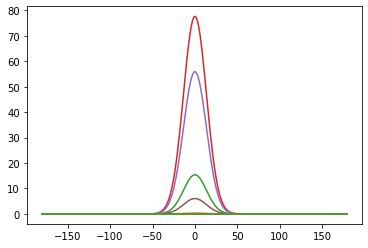

In [7]:
print(hbump.shape)
for i in range(0,129,10):
    plt.plot(np.rad2deg(lons1d),hbump[i,:])
plt.show()

In [8]:
# initial vorticity, divergence in spectral space
vrtspec, divspec =  x.getvrtdivspec(ug,vg,ntrunc)

In [9]:
# create spectral indexing arrays, laplacian operator and its inverse.
indxm, indxn = getspecindx(ntrunc)
lap = -(indxn*(indxn+1.0)/rsphere**2).astype(np.float32)
ilap = np.zeros(lap.shape, np.float32)
ilap[1:] = 1./lap[1:]
hyperdiff_fact = np.exp((-dt/efold)*(lap/lap[-1])**(ndiss/2))


In [10]:
# solve nonlinear balance eqn to get initial zonal geopotential,
# add localized bump (not balanced).
vrtg = x.spectogrd(vrtspec)
tmpg1 = ug*(vrtg+f); tmpg2 = vg*(vrtg+f)
tmpspec1, tmpspec2 = x.getvrtdivspec(tmpg1,tmpg2,ntrunc)
tmpspec2 = x.grdtospec(0.5*(ug**2+vg**2),ntrunc)
phispec = ilap*tmpspec1 - tmpspec2
phig = grav*(hbar + hbump) + x.spectogrd(phispec)
phispec = x.grdtospec(phig,ntrunc)

In [26]:
# initialize spectral tendency arrays
# (3,) is interpreted as a colletion; the addition operator concatenates: (1,)+(2,)=(1,2)
ddivdtspec = np.zeros(vrtspec.shape+(3,), np.complex64)
dvrtdtspec = np.zeros(vrtspec.shape+(3,), np.complex64)
dphidtspec = np.zeros(vrtspec.shape+(3,), np.complex64)
nnew = 0; nnow = 1; nold = 2

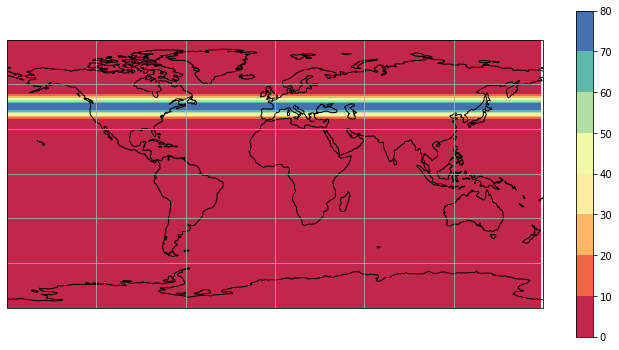

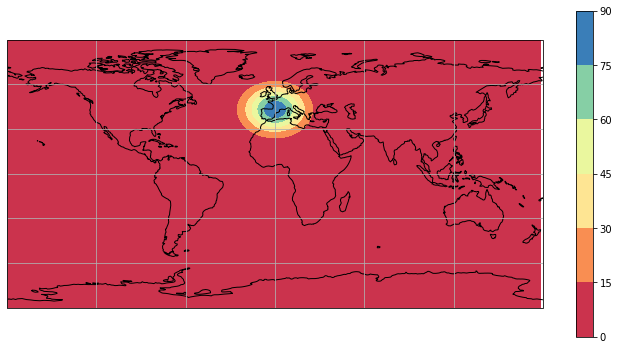

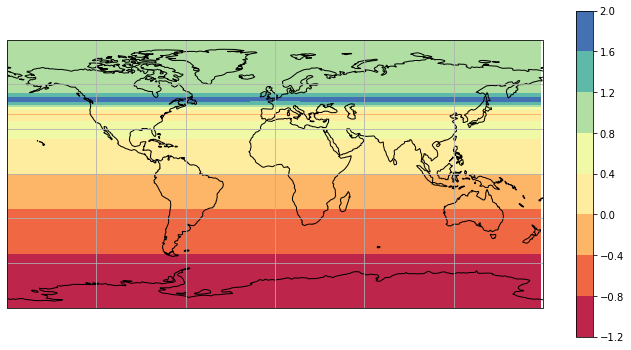

In [27]:
#potential vorticity
pvg = (0.5*hbar*grav/omega)*(vrtg+f)/phig

plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.gridlines()
#im=plt.contourf(lons1d*180/np.pi, lats1d*180.0/np.pi, pvg, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
im=plt.contourf(lons1d*180/np.pi, lats1d*180.0/np.pi, ug, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
#im=plt.contourf(lons1d*180/np.pi, lats1d*180.0/np.pi, vrtg, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
plt.colorbar(im)
plt.show()


plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.gridlines()
im=plt.contourf(lons1d*180/np.pi, lats1d*180.0/np.pi, hbump, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
plt.colorbar(im)
plt.show()

plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.gridlines()
im=plt.contourf(lons1d*180/np.pi, lats1d*180.0/np.pi, pvg, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
#im=plt.contourf(lons1d*180/np.pi, lats1d*180.0/np.pi, ug, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
#im=plt.contourf(lons1d*180/np.pi, lats1d*180.0/np.pi, vrtg, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
plt.colorbar(im)
plt.show()



In [11]:
# time loop.

'''
http://rhinohide.org/co2/publications/models/GFDL/Bourke-1972-SpectralModel.pdf
Bourke, An efficient, One-Level, Primitive-Equation Spectral Model
dxhi/dt = -div[(xhi+f)*V] where xhi=curl[V] and V is horizontal velocity vector; f is coriolis 2*Omega*sin(latitude)
dD/dt = curl[(xhi+f)*V] - lap[Phi' + V^2/2] where D is div[V] and Phi=Phibar+Phi'=geopotential gz
dPhi'/dt = -div[Phi'*V] - Phibar*D

in code below:
vrtg is xhi
div is D

Phi is not separated into Phi' and Phibar
dPhi / dt = -div[Phi*V]
lap[Phi'] = lap[Phi]

'''

time1 = time.time()

for ncycle in range(itmax+1):
    t = ncycle*dt
# get vort,u,v,phi on grid
    vrtg = x.spectogrd(vrtspec)
    ug,vg = x.getuv(vrtspec,divspec)
    phig = x.spectogrd(phispec)
    print('t=%6.2f hours: min/max %6.2f, %6.2f' % (t/3600.,vg.min(), vg.max()))
# compute tendencies.
    tmpg1 = ug*(vrtg+f); tmpg2 = vg*(vrtg+f)
    ddivdtspec[:,nnew], dvrtdtspec[:,nnew] = x.getvrtdivspec(tmpg1,tmpg2,ntrunc)
    dvrtdtspec[:,nnew] *= -1
    tmpg1 = ug*phig; tmpg2 = vg*phig
    tmpspec, dphidtspec[:,nnew] = x.getvrtdivspec(tmpg1,tmpg2,ntrunc)
    dphidtspec[:,nnew] *= -1
    tmpspec = x.grdtospec(phig+0.5*(ug**2+vg**2),ntrunc)
    ddivdtspec[:,nnew] += -lap*tmpspec
# update vort,div,phiv with third-order adams-bashforth.
# forward euler, then 2nd-order adams-bashforth time steps to start.
    if ncycle == 0:
        dvrtdtspec[:,nnow] = dvrtdtspec[:,nnew]
        dvrtdtspec[:,nold] = dvrtdtspec[:,nnew]
        ddivdtspec[:,nnow] = ddivdtspec[:,nnew]
        ddivdtspec[:,nold] = ddivdtspec[:,nnew]
        dphidtspec[:,nnow] = dphidtspec[:,nnew]
        dphidtspec[:,nold] = dphidtspec[:,nnew]
    elif ncycle == 1:
        dvrtdtspec[:,nold] = dvrtdtspec[:,nnew]
        ddivdtspec[:,nold] = ddivdtspec[:,nnew]
        dphidtspec[:,nold] = dphidtspec[:,nnew]
    vrtspec += dt*( \
    (23./12.)*dvrtdtspec[:,nnew] - (16./12.)*dvrtdtspec[:,nnow]+ \
    (5./12.)*dvrtdtspec[:,nold] )
    divspec += dt*( \
    (23./12.)*ddivdtspec[:,nnew] - (16./12.)*ddivdtspec[:,nnow]+ \
    (5./12.)*ddivdtspec[:,nold] )
    phispec += dt*( \
    (23./12.)*dphidtspec[:,nnew] - (16./12.)*dphidtspec[:,nnow]+ \
    (5./12.)*dphidtspec[:,nold] )
    # implicit hyperdiffusion for vort and div.
    vrtspec *= hyperdiff_fact
    divspec *= hyperdiff_fact
# switch indices, do next time step.
    nsav1 = nnew; nsav2 = nnow
    nnew = nold; nnow = nsav1; nold = nsav2

time2 = time.time()
print('elapsed time = ',time2-time1)

t=  0.00 hours: min/max  -0.00,  -0.00
t=  0.04 hours: min/max  -0.07,   0.07
t=  0.08 hours: min/max  -0.14,   0.14
t=  0.12 hours: min/max  -0.20,   0.20
t=  0.17 hours: min/max  -0.27,   0.27
t=  0.21 hours: min/max  -0.33,   0.34
t=  0.25 hours: min/max  -0.39,   0.40
t=  0.29 hours: min/max  -0.45,   0.46
t=  0.33 hours: min/max  -0.51,   0.52
t=  0.38 hours: min/max  -0.57,   0.58
t=  0.42 hours: min/max  -0.62,   0.63
t=  0.46 hours: min/max  -0.67,   0.68
t=  0.50 hours: min/max  -0.71,   0.73
t=  0.54 hours: min/max  -0.76,   0.77
t=  0.58 hours: min/max  -0.80,   0.82
t=  0.62 hours: min/max  -0.83,   0.85
t=  0.67 hours: min/max  -0.87,   0.89
t=  0.71 hours: min/max  -0.89,   0.92
t=  0.75 hours: min/max  -0.92,   0.94
t=  0.79 hours: min/max  -0.94,   0.97
t=  0.83 hours: min/max  -0.96,   0.99
t=  0.88 hours: min/max  -0.97,   1.00
t=  0.92 hours: min/max  -0.99,   1.02
t=  0.96 hours: min/max  -0.99,   1.03
t=  1.00 hours: min/max  -1.00,   1.03
t=  1.04 hours: min/max  

t=  9.25 hours: min/max  -0.66,   0.41
t=  9.29 hours: min/max  -0.66,   0.41
t=  9.33 hours: min/max  -0.66,   0.42
t=  9.38 hours: min/max  -0.66,   0.42
t=  9.42 hours: min/max  -0.66,   0.42
t=  9.46 hours: min/max  -0.66,   0.42
t=  9.50 hours: min/max  -0.66,   0.42
t=  9.54 hours: min/max  -0.66,   0.42
t=  9.58 hours: min/max  -0.66,   0.42
t=  9.62 hours: min/max  -0.67,   0.42
t=  9.67 hours: min/max  -0.67,   0.42
t=  9.71 hours: min/max  -0.67,   0.42
t=  9.75 hours: min/max  -0.67,   0.42
t=  9.79 hours: min/max  -0.67,   0.42
t=  9.83 hours: min/max  -0.67,   0.41
t=  9.88 hours: min/max  -0.67,   0.41
t=  9.92 hours: min/max  -0.67,   0.41
t=  9.96 hours: min/max  -0.67,   0.41
t= 10.00 hours: min/max  -0.67,   0.41
t= 10.04 hours: min/max  -0.67,   0.40
t= 10.08 hours: min/max  -0.67,   0.40
t= 10.12 hours: min/max  -0.67,   0.40
t= 10.17 hours: min/max  -0.67,   0.40
t= 10.21 hours: min/max  -0.68,   0.40
t= 10.25 hours: min/max  -0.68,   0.39
t= 10.29 hours: min/max  

t= 18.50 hours: min/max  -0.86,   0.76
t= 18.54 hours: min/max  -0.86,   0.77
t= 18.58 hours: min/max  -0.86,   0.77
t= 18.62 hours: min/max  -0.87,   0.77
t= 18.67 hours: min/max  -0.87,   0.77
t= 18.71 hours: min/max  -0.87,   0.78
t= 18.75 hours: min/max  -0.87,   0.78
t= 18.79 hours: min/max  -0.87,   0.78
t= 18.83 hours: min/max  -0.87,   0.78
t= 18.88 hours: min/max  -0.87,   0.79
t= 18.92 hours: min/max  -0.87,   0.79
t= 18.96 hours: min/max  -0.87,   0.79
t= 19.00 hours: min/max  -0.88,   0.80
t= 19.04 hours: min/max  -0.88,   0.80
t= 19.08 hours: min/max  -0.88,   0.80
t= 19.12 hours: min/max  -0.88,   0.80
t= 19.17 hours: min/max  -0.88,   0.81
t= 19.21 hours: min/max  -0.88,   0.81
t= 19.25 hours: min/max  -0.88,   0.82
t= 19.29 hours: min/max  -0.88,   0.82
t= 19.33 hours: min/max  -0.88,   0.82
t= 19.38 hours: min/max  -0.88,   0.82
t= 19.42 hours: min/max  -0.88,   0.82
t= 19.46 hours: min/max  -0.89,   0.83
t= 19.50 hours: min/max  -0.89,   0.83
t= 19.54 hours: min/max  

t= 27.67 hours: min/max  -1.05,   1.37
t= 27.71 hours: min/max  -1.05,   1.37
t= 27.75 hours: min/max  -1.05,   1.38
t= 27.79 hours: min/max  -1.05,   1.38
t= 27.83 hours: min/max  -1.05,   1.39
t= 27.88 hours: min/max  -1.05,   1.39
t= 27.92 hours: min/max  -1.05,   1.40
t= 27.96 hours: min/max  -1.05,   1.40
t= 28.00 hours: min/max  -1.05,   1.40
t= 28.04 hours: min/max  -1.05,   1.41
t= 28.08 hours: min/max  -1.05,   1.41
t= 28.12 hours: min/max  -1.05,   1.42
t= 28.17 hours: min/max  -1.05,   1.42
t= 28.21 hours: min/max  -1.05,   1.43
t= 28.25 hours: min/max  -1.05,   1.43
t= 28.29 hours: min/max  -1.05,   1.44
t= 28.33 hours: min/max  -1.05,   1.44
t= 28.38 hours: min/max  -1.05,   1.44
t= 28.42 hours: min/max  -1.05,   1.45
t= 28.46 hours: min/max  -1.05,   1.45
t= 28.50 hours: min/max  -1.05,   1.46
t= 28.54 hours: min/max  -1.05,   1.46
t= 28.58 hours: min/max  -1.05,   1.46
t= 28.62 hours: min/max  -1.05,   1.47
t= 28.67 hours: min/max  -1.05,   1.47
t= 28.71 hours: min/max  

t= 36.83 hours: min/max  -1.41,   2.12
t= 36.88 hours: min/max  -1.42,   2.13
t= 36.92 hours: min/max  -1.42,   2.13
t= 36.96 hours: min/max  -1.42,   2.14
t= 37.00 hours: min/max  -1.42,   2.15
t= 37.04 hours: min/max  -1.43,   2.16
t= 37.08 hours: min/max  -1.43,   2.16
t= 37.12 hours: min/max  -1.43,   2.17
t= 37.17 hours: min/max  -1.44,   2.18
t= 37.21 hours: min/max  -1.44,   2.19
t= 37.25 hours: min/max  -1.44,   2.20
t= 37.29 hours: min/max  -1.44,   2.21
t= 37.33 hours: min/max  -1.45,   2.22
t= 37.38 hours: min/max  -1.45,   2.23
t= 37.42 hours: min/max  -1.45,   2.24
t= 37.46 hours: min/max  -1.46,   2.25
t= 37.50 hours: min/max  -1.46,   2.26
t= 37.54 hours: min/max  -1.46,   2.27
t= 37.58 hours: min/max  -1.47,   2.28
t= 37.62 hours: min/max  -1.47,   2.29
t= 37.67 hours: min/max  -1.47,   2.30
t= 37.71 hours: min/max  -1.48,   2.31
t= 37.75 hours: min/max  -1.48,   2.32
t= 37.79 hours: min/max  -1.49,   2.33
t= 37.83 hours: min/max  -1.49,   2.35
t= 37.88 hours: min/max  

t= 46.12 hours: min/max  -3.09,   3.52
t= 46.17 hours: min/max  -3.10,   3.52
t= 46.21 hours: min/max  -3.11,   3.53
t= 46.25 hours: min/max  -3.13,   3.53
t= 46.29 hours: min/max  -3.14,   3.54
t= 46.33 hours: min/max  -3.15,   3.54
t= 46.38 hours: min/max  -3.16,   3.55
t= 46.42 hours: min/max  -3.18,   3.55
t= 46.46 hours: min/max  -3.19,   3.56
t= 46.50 hours: min/max  -3.20,   3.56
t= 46.54 hours: min/max  -3.22,   3.57
t= 46.58 hours: min/max  -3.23,   3.57
t= 46.62 hours: min/max  -3.24,   3.58
t= 46.67 hours: min/max  -3.26,   3.58
t= 46.71 hours: min/max  -3.27,   3.58
t= 46.75 hours: min/max  -3.28,   3.59
t= 46.79 hours: min/max  -3.30,   3.59
t= 46.83 hours: min/max  -3.31,   3.60
t= 46.88 hours: min/max  -3.32,   3.60
t= 46.92 hours: min/max  -3.34,   3.61
t= 46.96 hours: min/max  -3.35,   3.61
t= 47.00 hours: min/max  -3.37,   3.62
t= 47.04 hours: min/max  -3.38,   3.62
t= 47.08 hours: min/max  -3.39,   3.63
t= 47.12 hours: min/max  -3.41,   3.63
t= 47.17 hours: min/max  

t= 55.29 hours: min/max  -6.10,   5.13
t= 55.33 hours: min/max  -6.11,   5.14
t= 55.38 hours: min/max  -6.13,   5.15
t= 55.42 hours: min/max  -6.14,   5.16
t= 55.46 hours: min/max  -6.16,   5.17
t= 55.50 hours: min/max  -6.17,   5.18
t= 55.54 hours: min/max  -6.18,   5.19
t= 55.58 hours: min/max  -6.20,   5.20
t= 55.62 hours: min/max  -6.22,   5.20
t= 55.67 hours: min/max  -6.24,   5.21
t= 55.71 hours: min/max  -6.26,   5.22
t= 55.75 hours: min/max  -6.27,   5.23
t= 55.79 hours: min/max  -6.29,   5.24
t= 55.83 hours: min/max  -6.31,   5.24
t= 55.88 hours: min/max  -6.33,   5.25
t= 55.92 hours: min/max  -6.35,   5.26
t= 55.96 hours: min/max  -6.37,   5.27
t= 56.00 hours: min/max  -6.39,   5.27
t= 56.04 hours: min/max  -6.40,   5.28
t= 56.08 hours: min/max  -6.42,   5.29
t= 56.12 hours: min/max  -6.44,   5.29
t= 56.17 hours: min/max  -6.46,   5.30
t= 56.21 hours: min/max  -6.48,   5.30
t= 56.25 hours: min/max  -6.50,   5.31
t= 56.29 hours: min/max  -6.52,   5.32
t= 56.33 hours: min/max  

t= 64.58 hours: min/max -10.67,   8.85
t= 64.62 hours: min/max -10.68,   8.89
t= 64.67 hours: min/max -10.70,   8.92
t= 64.71 hours: min/max -10.71,   8.96
t= 64.75 hours: min/max -10.72,   8.99
t= 64.79 hours: min/max -10.73,   9.02
t= 64.83 hours: min/max -10.74,   9.06
t= 64.88 hours: min/max -10.75,   9.09
t= 64.92 hours: min/max -10.76,   9.12
t= 64.96 hours: min/max -10.76,   9.14
t= 65.00 hours: min/max -10.78,   9.17
t= 65.04 hours: min/max -10.80,   9.20
t= 65.08 hours: min/max -10.81,   9.22
t= 65.12 hours: min/max -10.83,   9.25
t= 65.17 hours: min/max -10.84,   9.28
t= 65.21 hours: min/max -10.86,   9.30
t= 65.25 hours: min/max -10.88,   9.33
t= 65.29 hours: min/max -10.90,   9.35
t= 65.33 hours: min/max -10.91,   9.38
t= 65.38 hours: min/max -10.93,   9.40
t= 65.42 hours: min/max -10.95,   9.42
t= 65.46 hours: min/max -10.97,   9.45
t= 65.50 hours: min/max -10.99,   9.47
t= 65.54 hours: min/max -11.01,   9.49
t= 65.58 hours: min/max -11.03,   9.51
t= 65.62 hours: min/max -

t= 73.79 hours: min/max -17.81,  16.50
t= 73.83 hours: min/max -17.86,  16.54
t= 73.88 hours: min/max -17.90,  16.59
t= 73.92 hours: min/max -17.95,  16.63
t= 73.96 hours: min/max -18.00,  16.67
t= 74.00 hours: min/max -18.04,  16.71
t= 74.04 hours: min/max -18.09,  16.76
t= 74.08 hours: min/max -18.13,  16.80
t= 74.12 hours: min/max -18.18,  16.84
t= 74.17 hours: min/max -18.22,  16.88
t= 74.21 hours: min/max -18.26,  16.93
t= 74.25 hours: min/max -18.31,  16.97
t= 74.29 hours: min/max -18.35,  17.01
t= 74.33 hours: min/max -18.39,  17.05
t= 74.38 hours: min/max -18.43,  17.09
t= 74.42 hours: min/max -18.47,  17.13
t= 74.46 hours: min/max -18.51,  17.17
t= 74.50 hours: min/max -18.55,  17.21
t= 74.54 hours: min/max -18.59,  17.25
t= 74.58 hours: min/max -18.63,  17.30
t= 74.62 hours: min/max -18.67,  17.34
t= 74.67 hours: min/max -18.71,  17.38
t= 74.71 hours: min/max -18.77,  17.43
t= 74.75 hours: min/max -18.82,  17.48
t= 74.79 hours: min/max -18.87,  17.53
t= 74.83 hours: min/max -

t= 83.21 hours: min/max -28.23,  28.21
t= 83.25 hours: min/max -28.28,  28.28
t= 83.29 hours: min/max -28.32,  28.34
t= 83.33 hours: min/max -28.37,  28.41
t= 83.38 hours: min/max -28.42,  28.47
t= 83.42 hours: min/max -28.47,  28.53
t= 83.46 hours: min/max -28.51,  28.59
t= 83.50 hours: min/max -28.56,  28.65
t= 83.54 hours: min/max -28.61,  28.71
t= 83.58 hours: min/max -28.65,  28.77
t= 83.62 hours: min/max -28.70,  28.82
t= 83.67 hours: min/max -28.75,  28.87
t= 83.71 hours: min/max -28.79,  28.92
t= 83.75 hours: min/max -28.84,  28.97
t= 83.79 hours: min/max -28.88,  29.02
t= 83.83 hours: min/max -28.92,  29.08
t= 83.88 hours: min/max -28.97,  29.14
t= 83.92 hours: min/max -29.04,  29.21
t= 83.96 hours: min/max -29.11,  29.27
t= 84.00 hours: min/max -29.18,  29.33
t= 84.04 hours: min/max -29.25,  29.39
t= 84.08 hours: min/max -29.31,  29.44
t= 84.12 hours: min/max -29.38,  29.50
t= 84.17 hours: min/max -29.44,  29.56
t= 84.21 hours: min/max -29.51,  29.61
t= 84.25 hours: min/max -

t= 92.38 hours: min/max -42.51,  40.04
t= 92.42 hours: min/max -42.62,  40.08
t= 92.46 hours: min/max -42.72,  40.11
t= 92.50 hours: min/max -42.83,  40.14
t= 92.54 hours: min/max -42.93,  40.17
t= 92.58 hours: min/max -43.02,  40.19
t= 92.62 hours: min/max -43.12,  40.22
t= 92.67 hours: min/max -43.21,  40.25
t= 92.71 hours: min/max -43.30,  40.27
t= 92.75 hours: min/max -43.39,  40.29
t= 92.79 hours: min/max -43.48,  40.31
t= 92.83 hours: min/max -43.56,  40.33
t= 92.88 hours: min/max -43.65,  40.36
t= 92.92 hours: min/max -43.73,  40.42
t= 92.96 hours: min/max -43.80,  40.47
t= 93.00 hours: min/max -43.88,  40.53
t= 93.04 hours: min/max -43.95,  40.58
t= 93.08 hours: min/max -44.02,  40.63
t= 93.12 hours: min/max -44.09,  40.68
t= 93.17 hours: min/max -44.16,  40.73
t= 93.21 hours: min/max -44.22,  40.78
t= 93.25 hours: min/max -44.28,  40.83
t= 93.29 hours: min/max -44.34,  40.88
t= 93.33 hours: min/max -44.39,  40.92
t= 93.38 hours: min/max -44.45,  40.97
t= 93.42 hours: min/max -

t=101.54 hours: min/max -55.17,  46.77
t=101.58 hours: min/max -55.18,  46.80
t=101.62 hours: min/max -55.18,  46.83
t=101.67 hours: min/max -55.18,  46.85
t=101.71 hours: min/max -55.18,  46.87
t=101.75 hours: min/max -55.17,  46.89
t=101.79 hours: min/max -55.16,  46.91
t=101.83 hours: min/max -55.15,  46.93
t=101.88 hours: min/max -55.13,  46.94
t=101.92 hours: min/max -55.11,  46.96
t=101.96 hours: min/max -55.09,  46.97
t=102.00 hours: min/max -55.08,  46.98
t=102.04 hours: min/max -55.12,  46.98
t=102.08 hours: min/max -55.15,  46.99
t=102.12 hours: min/max -55.18,  46.99
t=102.17 hours: min/max -55.21,  46.99
t=102.21 hours: min/max -55.23,  46.99
t=102.25 hours: min/max -55.25,  46.99
t=102.29 hours: min/max -55.27,  46.98
t=102.33 hours: min/max -55.29,  46.98
t=102.38 hours: min/max -55.30,  46.97
t=102.42 hours: min/max -55.31,  46.96
t=102.46 hours: min/max -55.32,  46.95
t=102.50 hours: min/max -55.33,  46.93
t=102.54 hours: min/max -55.33,  46.92
t=102.58 hours: min/max -

t=110.58 hours: min/max -56.21,  48.11
t=110.62 hours: min/max -56.15,  48.09
t=110.67 hours: min/max -56.09,  48.07
t=110.71 hours: min/max -56.03,  48.05
t=110.75 hours: min/max -55.97,  48.05
t=110.79 hours: min/max -55.90,  48.09
t=110.83 hours: min/max -55.83,  48.12
t=110.88 hours: min/max -55.77,  48.15
t=110.92 hours: min/max -55.80,  48.18
t=110.96 hours: min/max -55.83,  48.21
t=111.00 hours: min/max -55.85,  48.24
t=111.04 hours: min/max -55.88,  48.26
t=111.08 hours: min/max -55.90,  48.29
t=111.12 hours: min/max -55.92,  48.31
t=111.17 hours: min/max -55.93,  48.33
t=111.21 hours: min/max -55.95,  48.35
t=111.25 hours: min/max -55.96,  48.36
t=111.29 hours: min/max -55.97,  48.38
t=111.33 hours: min/max -55.98,  48.39
t=111.38 hours: min/max -55.99,  48.40
t=111.42 hours: min/max -55.99,  48.41
t=111.46 hours: min/max -55.99,  48.42
t=111.50 hours: min/max -55.99,  48.42
t=111.54 hours: min/max -55.99,  48.43
t=111.58 hours: min/max -55.98,  48.43
t=111.62 hours: min/max -

t=119.46 hours: min/max -56.69,  47.48
t=119.50 hours: min/max -56.67,  47.46
t=119.54 hours: min/max -56.65,  47.45
t=119.58 hours: min/max -56.63,  47.43
t=119.62 hours: min/max -56.60,  47.41
t=119.67 hours: min/max -56.57,  47.40
t=119.71 hours: min/max -56.54,  47.44
t=119.75 hours: min/max -56.50,  47.47
t=119.79 hours: min/max -56.46,  47.51
t=119.83 hours: min/max -56.42,  47.54
t=119.88 hours: min/max -56.38,  47.57
t=119.92 hours: min/max -56.33,  47.60
t=119.96 hours: min/max -56.28,  47.62
t=120.00 hours: min/max -56.22,  47.65
t=120.04 hours: min/max -56.17,  47.67
t=120.08 hours: min/max -56.18,  47.69
t=120.12 hours: min/max -56.20,  47.70
t=120.17 hours: min/max -56.23,  47.72
t=120.21 hours: min/max -56.25,  47.73
t=120.25 hours: min/max -56.27,  47.74
t=120.29 hours: min/max -56.29,  47.75
t=120.33 hours: min/max -56.31,  47.75
t=120.38 hours: min/max -56.32,  47.76
t=120.42 hours: min/max -56.34,  47.76
t=120.46 hours: min/max -56.35,  47.75
t=120.50 hours: min/max -

t=128.33 hours: min/max -52.97,  47.51
t=128.38 hours: min/max -52.98,  47.51
t=128.42 hours: min/max -52.99,  47.50
t=128.46 hours: min/max -52.99,  47.49
t=128.50 hours: min/max -52.99,  47.48
t=128.54 hours: min/max -52.99,  47.47
t=128.58 hours: min/max -52.98,  47.45
t=128.62 hours: min/max -52.98,  47.43
t=128.67 hours: min/max -52.97,  47.40
t=128.71 hours: min/max -52.96,  47.43
t=128.75 hours: min/max -52.95,  47.47
t=128.79 hours: min/max -52.94,  47.50
t=128.83 hours: min/max -52.92,  47.53
t=128.88 hours: min/max -52.91,  47.56
t=128.92 hours: min/max -52.89,  47.59
t=128.96 hours: min/max -52.87,  47.62
t=129.00 hours: min/max -52.84,  47.64
t=129.04 hours: min/max -52.82,  47.67
t=129.08 hours: min/max -52.79,  47.69
t=129.12 hours: min/max -52.77,  47.70
t=129.17 hours: min/max -52.74,  47.72
t=129.21 hours: min/max -52.72,  47.73
t=129.25 hours: min/max -52.69,  47.74
t=129.29 hours: min/max -52.66,  47.75
t=129.33 hours: min/max -52.62,  47.75
t=129.38 hours: min/max -

t=137.54 hours: min/max -54.48,  46.13
t=137.58 hours: min/max -54.49,  46.11
t=137.62 hours: min/max -54.49,  46.08
t=137.67 hours: min/max -54.49,  46.06
t=137.71 hours: min/max -54.52,  46.03
t=137.75 hours: min/max -54.57,  45.99
t=137.79 hours: min/max -54.62,  45.96
t=137.83 hours: min/max -54.66,  45.92
t=137.88 hours: min/max -54.70,  45.87
t=137.92 hours: min/max -54.74,  45.83
t=137.96 hours: min/max -54.78,  45.78
t=138.00 hours: min/max -54.81,  45.74
t=138.04 hours: min/max -54.84,  45.74
t=138.08 hours: min/max -54.87,  45.74
t=138.12 hours: min/max -54.89,  45.73
t=138.17 hours: min/max -54.91,  45.72
t=138.21 hours: min/max -54.92,  45.71
t=138.25 hours: min/max -54.94,  45.72
t=138.29 hours: min/max -54.95,  45.75
t=138.33 hours: min/max -54.95,  45.78
t=138.38 hours: min/max -54.96,  45.81
t=138.42 hours: min/max -54.96,  45.83
t=138.46 hours: min/max -54.95,  45.85
t=138.50 hours: min/max -54.95,  45.86
t=138.54 hours: min/max -54.94,  45.88
t=138.58 hours: min/max -

max/min PV -0.9900840699831869 1.7734430634900622


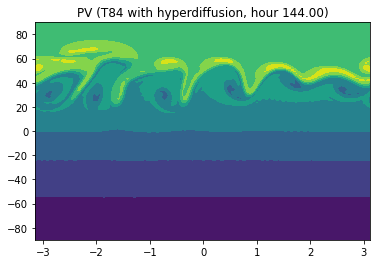

In [12]:
# make a orthographic plot of potential vorticity.
#m = Basemap(projection='ortho',lat_0=45,lon_0=-100)
# dimensionless PV
pvg = (0.5*hbar*grav/omega)*(vrtg+f)/phig
print('max/min PV',pvg.min(), pvg.max())
#pvg,lons1d = addcyclic(pvg,lons1d*180./np.pi)
lons, lats = np.meshgrid(lons1d,lats1d*180./np.pi)

#x,y = m(lons,lats)
levs = np.arange(-0.2,1.801,0.1)
#m.drawmeridians(np.arange(-180,180,60))
#m.drawparallels(np.arange(-80,81,20))

#CS=m.contourf(x,y,pvg,levs,cmap=plt.cm.spectral,extend='both')
#m.colorbar()

plt.contourf(lons, lats, pvg)

plt.title('PV (T%s with hyperdiffusion, hour %6.2f)' % (ntrunc,t/3600.))
plt.show()

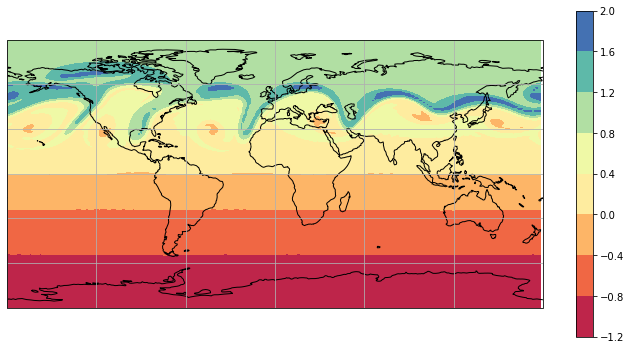

/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/cr

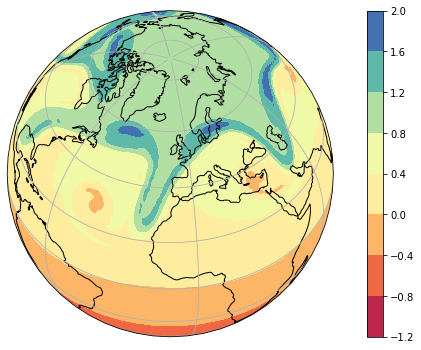

In [13]:
#https://scitools.org.uk/cartopy/docs/latest/gallery/scalar_data/waves.html

plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())

#ax.add_feature(cfeature.OCEAN, zorder=0)
#ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.coastlines()
ax.set_global()
ax.gridlines()


im=plt.contourf(lons1d*180/np.pi, lats1d*180.0/np.pi, pvg, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)

plt.colorbar(im)

plt.show()


plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Orthographic(-10, 45))

#ax.add_feature(cfeature.OCEAN, zorder=0)
#ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.coastlines()
ax.set_global()
ax.gridlines()

#ax.contourf(np.rad2deg(lons1d), np.rad2deg(lats1d), pvg, transform=ccrs.PlateCarree(), cmap='nipy_spectral')
im=ax.contourf(np.rad2deg(lons1d), np.rad2deg(lats1d), pvg, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
plt.colorbar(im)
plt.show()


